<a href="https://colab.research.google.com/github/evakato/ComputerVision4/blob/main/cv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check if gpu is available:

In [10]:
import torch
device = (
    #Nvidia GPU
    "cuda" 
    if torch.cuda.is_available()
    #Apple GPU
    else "mps"
    if torch.backends.mps.is_available()
    #Other
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Preprocessing
- Import the Fashion MNIST dataset
- Create validation set

In [11]:
import torchvision.transforms
from torchvision.transforms import ToTensor, Normalize
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt

batch_size = 32


transform = torchvision.transforms.Compose([ToTensor(), Normalize((0.5,),(0.5,))]) #normalisation could probably be more accurate by calculating dataset mean and std
train_data = datasets.FashionMNIST('Data', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('Data', download=True, train=False, transform=transform)
trainval_dataloader = DataLoader(train_data, batch_size, shuffle=True)

splitlength = [50000,10000] 
train_data, val_data = random_split(train_data, splitlength)

train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)


Sample image from train_data:

torch.Size([1, 28, 28]) 3


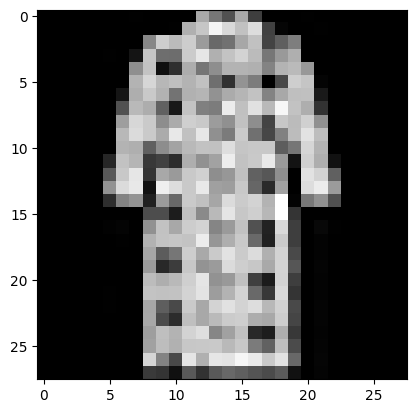

In [12]:
image, label = train_data[0]
print(image.shape, label)
plt.imshow(image[0], cmap = 'gray')

## Recreating the LeNet-5 architecture as baseline. 
The model takes as input a greyscale image of size 28x28x1 and has 10 outputs, one for each class. 
The model is trained using cross-entropy loss, Adam optimizer with a learning rate of 0.001. Use torch.nn.init.kaiming_uniform to initialize your weights.


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import kaiming_uniform_, zeros_

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),  # 16 channels, 5x5 feature map size 
            #NOTE: isn't this supposed to be 16*5*5?
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

Auxilliary functions:

In [14]:
from torchkeras import summary

model = LeNet5()

def check_weights(model):
    for param in model.parameters():
        print(param.data)
    
def save_weights(model, name):
    torch.save(model.state_dict(), name)

def summarize(model):
    summary(model=model, input_shape=(1,28,28))

summarize(model)


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                             [-1, 6, 28, 28]                  156
ReLU-2                               [-1, 6, 28, 28]                    0
AvgPool2d-3                          [-1, 6, 14, 14]                    0
Conv2d-4                            [-1, 16, 10, 10]                2,416
ReLU-5                              [-1, 16, 10, 10]                    0
AvgPool2d-6                           [-1, 16, 5, 5]                    0
Flatten-7                                  [-1, 400]                    0
Linear-8                                   [-1, 120]               48,120
ReLU-9                                     [-1, 120]                    0
Linear-10                                   [-1, 84]               10,164
ReLU-11                                     [-1, 84]                    0
Linear-12                            

## Training and Testing

In [17]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train(loader, model, criterion, optimizer):
    model.train()

    for n, batch in enumerate(tqdm(loader)):
        X,y = batch
        optimizer.zero_grad()
        
        pred = model(X)
        
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()

def test(loader, model, criterion):
    model.eval()
    size = len(loader.dataset)
    batches = len(loader)
    total_loss = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch in loader:
            X,y = batch
            pred = model(X)
            
            loss = criterion(pred, y)
            total_loss += loss.item()

            y = y.data.numpy()
            y_true.extend(y)
            pred = pred.argmax(1).data.numpy()
            y_pred.extend(pred)

    loss = total_loss / batches
    accuracy = accuracy_score(y_true, y_pred)

    return y_true, y_pred, loss, accuracy
        

Epoch 1
----------------
Training:


100%|██████████| 1563/1563 [00:32<00:00, 47.71it/s]


Testing:
train-set - loss: 0.35543578029422523, accuracy: 0.87012
test-set - loss: 0.3548857271671295, accuracy: 0.8775
----------------
Epoch 2
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 51.24it/s]


Testing:
train-set - loss: 0.2959158852844191, accuracy: 0.89078
test-set - loss: 0.3135922533778337, accuracy: 0.888
----------------
Epoch 3
----------------
Training:


100%|██████████| 1563/1563 [00:31<00:00, 50.19it/s]


Testing:
train-set - loss: 0.2740796985067737, accuracy: 0.89934
test-set - loss: 0.3004145553698555, accuracy: 0.8928
----------------
Epoch 4
----------------
Training:


100%|██████████| 1563/1563 [00:36<00:00, 42.73it/s]


Testing:
train-set - loss: 0.23810347077160865, accuracy: 0.91156
test-set - loss: 0.2715286310440816, accuracy: 0.9029
----------------
Epoch 5
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 50.79it/s]


Testing:
train-set - loss: 0.21638690345871167, accuracy: 0.92104
test-set - loss: 0.2616097424595882, accuracy: 0.904
----------------
Epoch 6
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 51.27it/s]


Testing:
train-set - loss: 0.2047362319769973, accuracy: 0.9247
test-set - loss: 0.2637535248772976, accuracy: 0.9059
----------------
Epoch 7
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 51.66it/s]


Testing:
train-set - loss: 0.18160612585996674, accuracy: 0.93272
test-set - loss: 0.2564075269554846, accuracy: 0.9113
----------------
Epoch 8
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 51.11it/s]


Testing:
train-set - loss: 0.16981917019797607, accuracy: 0.93786
test-set - loss: 0.24968993917893106, accuracy: 0.9115
----------------
Epoch 9
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 50.99it/s]


Testing:
train-set - loss: 0.16364408228772806, accuracy: 0.93864
test-set - loss: 0.2532714075757006, accuracy: 0.907
----------------
Epoch 10
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 51.10it/s]


Testing:
train-set - loss: 0.15059490582082832, accuracy: 0.94452
test-set - loss: 0.2616806718559501, accuracy: 0.911
----------------
Epoch 11
----------------
Training:


100%|██████████| 1563/1563 [00:29<00:00, 52.23it/s]


Testing:
train-set - loss: 0.1375659332906807, accuracy: 0.94824
test-set - loss: 0.2596661005698787, accuracy: 0.9129
----------------
Epoch 12
----------------
Training:


100%|██████████| 1563/1563 [00:32<00:00, 48.14it/s]


Testing:
train-set - loss: 0.13321417521641268, accuracy: 0.94978
test-set - loss: 0.27349135390342993, accuracy: 0.9118
----------------
Epoch 13
----------------
Training:


100%|██████████| 1563/1563 [00:33<00:00, 45.97it/s]


Testing:
train-set - loss: 0.1292574413606965, accuracy: 0.95222
test-set - loss: 0.2842463316253056, accuracy: 0.9125
----------------
Epoch 14
----------------
Training:


100%|██████████| 1563/1563 [00:30<00:00, 50.84it/s]


Testing:
train-set - loss: 0.11816301018622914, accuracy: 0.95528
test-set - loss: 0.3034523161657797, accuracy: 0.9104
----------------
Epoch 15
----------------
Training:


100%|██████████| 1563/1563 [00:35<00:00, 43.91it/s]


Testing:
train-set - loss: 0.09726907643272052, accuracy: 0.96446
test-set - loss: 0.28422985136949314, accuracy: 0.9127
----------------


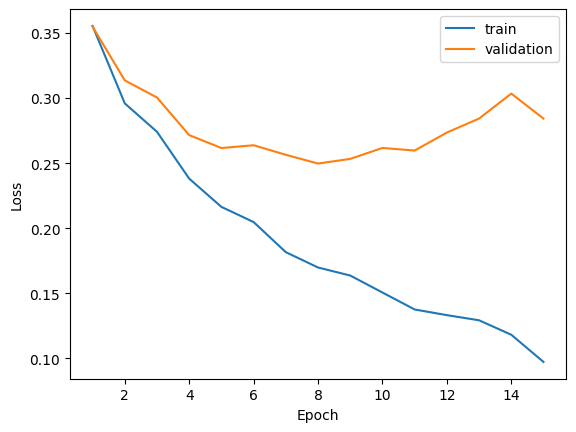

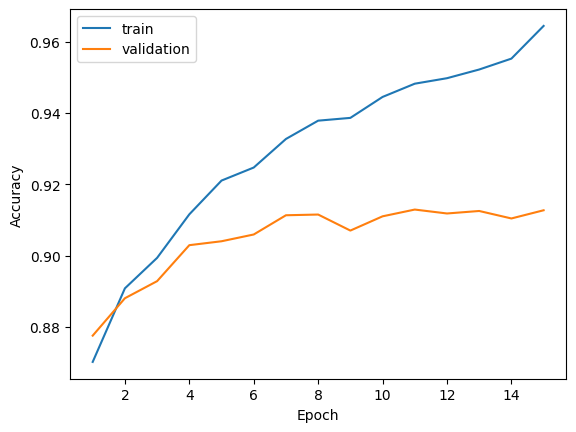

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.88      0.87      1009
     Trouser       0.99      0.98      0.98       994
    Pullover       0.88      0.88      0.88      1048
       Dress       0.86      0.92      0.89       975
        Coat       0.87      0.87      0.87       984
      Sandal       0.97      0.99      0.98       981
       Shirt       0.79      0.72      0.76       976
     Sneaker       0.97      0.94      0.95      1036
         Bag       0.98      0.98      0.98       974
  Ankle Boot       0.96      0.97      0.96      1023

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



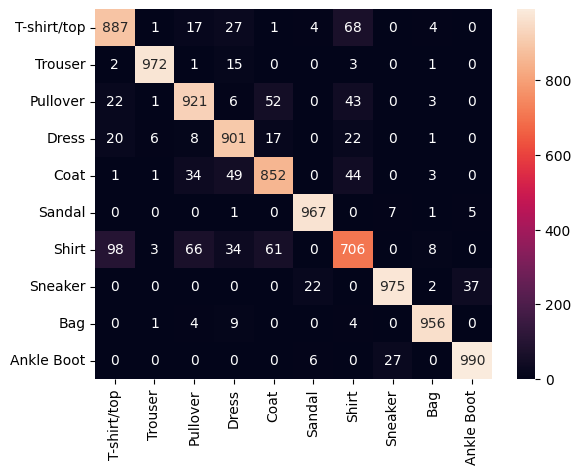

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses_train = []
losses_test = []
accs_train = []
accs_test = []

def train_test_loop(model, criterion, optimizer, epochs, loader_train=train_dataloader, loader_test=val_dataloader):
    for i in range(epochs):
        print(f"Epoch {i+1}\n----------------")
        print("Training:")
        train(loader=loader_train, model=model, criterion=criterion, optimizer=optimizer)
    
        print("Testing:")
        y_true_train, y_pred_train, loss_train, acc_train = test(loader=loader_train, model=model, criterion=criterion)
        print(f"train-set - loss: {loss_train}, accuracy: {acc_train}")
        y_true_test, y_pred_test, loss_test, acc_test = test(loader=loader_test, model=model, criterion=criterion)
        print(f"test-set - loss: {loss_test}, accuracy: {acc_test}")
    
        losses_train.append(loss_train)
        losses_test.append(loss_test)
        accs_train.append(acc_train)
        accs_test.append(acc_test)
        print("----------------")

    return y_true_test, y_pred_test
 

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(conf_matrix, classes, classes)
    sn.heatmap(conf_matrix, annot=True, fmt= 'g')
    cr = classification_report(y_true, y_pred, target_names=classes)
    print(cr)

def plot_loss(train_losses, test_losses, epochs):
    plt.plot(range(1, epochs+1), train_losses, label='train')
    plt.plot(range(1, epochs+1), test_losses, label='validation')
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

def plot_acc(accs_train, accs_test, epochs):
    plt.plot(range(1, epochs+1), accs_train, label='train')
    plt.plot(range(1, epochs+1), accs_test, label='validation')
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()    

y_true_test, y_pred_test = train_test_loop(model, criterion, optimizer, epochs)
plot_loss(losses_train, losses_test, epochs)
plot_acc(accs_train, accs_test, epochs)
evaluate(y_true_test,y_pred_test)


## Model variants.

Variant 1: LeNet + More Kernels

In [ ]:
class Var1(nn.Module): 
    def __init__(self):
        super(Var1, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(26 * 5 * 5, 120),  # 16 channels, 5x5 feature map size
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

Variant 2: LeNet + More Kernels + Dropout layers

In [ ]:
# INCREASED KERNELS + DROPOUT
class Var2(nn.Module):
    def __init__(self):
        super(Var2, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(26*5*5, 120),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

Variant 3: LeNet + More Kernels + Dropout layers + L2 Regularization

In [ ]:
class Var3(nn.Module):
    def __init__(self):
        super(Var3, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(26*5*5, 120),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

Variant 4: LeNet + More Kernels + Dropout layers + L2 Regularization + Lower learning rate

In [ ]:
class Var4(nn.Module):
    def __init__(self):
        super(Var4, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(26*5*5, 120),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)
    
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

Epoch 1
----------------
Training:


  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [00:38<00:00, 40.73it/s]


Testing:
train-set - loss: 0.3174647533609481, accuracy: 0.8837
test-set - loss: 0.3348537806076364, accuracy: 0.8784
----------------
Epoch 2
----------------
Training:


100%|██████████| 1563/1563 [00:39<00:00, 39.88it/s]


Testing:
train-set - loss: 0.2738337492116239, accuracy: 0.90044
test-set - loss: 0.2959697712748386, accuracy: 0.8934
----------------
Epoch 3
----------------
Training:


100%|██████████| 1563/1563 [00:39<00:00, 39.37it/s]


Testing:
train-set - loss: 0.23321227295060837, accuracy: 0.91538
test-set - loss: 0.26723901666224764, accuracy: 0.9013
----------------
Epoch 4
----------------
Training:


100%|██████████| 1563/1563 [00:41<00:00, 37.63it/s]


Testing:
train-set - loss: 0.20707485013863672, accuracy: 0.92372
test-set - loss: 0.25480880532949307, accuracy: 0.9065
----------------
Epoch 5
----------------
Training:


100%|██████████| 1563/1563 [00:39<00:00, 39.64it/s]


Testing:
train-set - loss: 0.20179131105709022, accuracy: 0.92502
test-set - loss: 0.25665125000281647, accuracy: 0.9062
----------------
Epoch 6
----------------
Training:


100%|██████████| 1563/1563 [00:39<00:00, 39.51it/s]


Testing:
train-set - loss: 0.2023495585286438, accuracy: 0.92364
test-set - loss: 0.27989495799135855, accuracy: 0.9033
----------------
Epoch 7
----------------
Training:


100%|██████████| 1563/1563 [00:39<00:00, 39.22it/s]


Testing:
train-set - loss: 0.17170191759521275, accuracy: 0.93364
test-set - loss: 0.25915549626460854, accuracy: 0.9031
----------------
Epoch 8
----------------
Training:


100%|██████████| 1563/1563 [00:40<00:00, 38.30it/s]


Testing:
train-set - loss: 0.13691724518073278, accuracy: 0.94922
test-set - loss: 0.2539462128552956, accuracy: 0.9135
----------------
Epoch 9
----------------
Training:


100%|██████████| 1563/1563 [00:44<00:00, 34.84it/s]


Testing:
train-set - loss: 0.1325252525507212, accuracy: 0.95042
test-set - loss: 0.26214434464756675, accuracy: 0.9143
----------------
Epoch 10
----------------
Training:


100%|██████████| 1563/1563 [00:39<00:00, 39.84it/s]


Testing:
train-set - loss: 0.11269456911126005, accuracy: 0.95956
test-set - loss: 0.25391754116446447, accuracy: 0.9173
----------------
Epoch 11
----------------
Training:


100%|██████████| 1563/1563 [00:41<00:00, 37.49it/s]


Testing:
train-set - loss: 0.11554724462786171, accuracy: 0.95792
test-set - loss: 0.28973360163287615, accuracy: 0.9106
----------------
Epoch 12
----------------
Training:


100%|██████████| 1563/1563 [00:39<00:00, 39.50it/s]


Testing:
train-set - loss: 0.09963358504992927, accuracy: 0.96252
test-set - loss: 0.28095014936204393, accuracy: 0.9137
----------------
Epoch 13
----------------
Training:


100%|██████████| 1563/1563 [00:41<00:00, 37.96it/s]


Testing:
train-set - loss: 0.08642460138637391, accuracy: 0.96682
test-set - loss: 0.302876986454601, accuracy: 0.916
----------------
Epoch 14
----------------
Training:


100%|██████████| 1563/1563 [00:41<00:00, 37.66it/s]


Testing:
train-set - loss: 0.08198679367858519, accuracy: 0.9693
test-set - loss: 0.3154410024384816, accuracy: 0.9143
----------------
Epoch 15
----------------
Training:


100%|██████████| 1563/1563 [00:40<00:00, 39.00it/s]


Testing:
train-set - loss: 0.0727039487446734, accuracy: 0.97406
test-set - loss: 0.308711149652426, accuracy: 0.9167
----------------


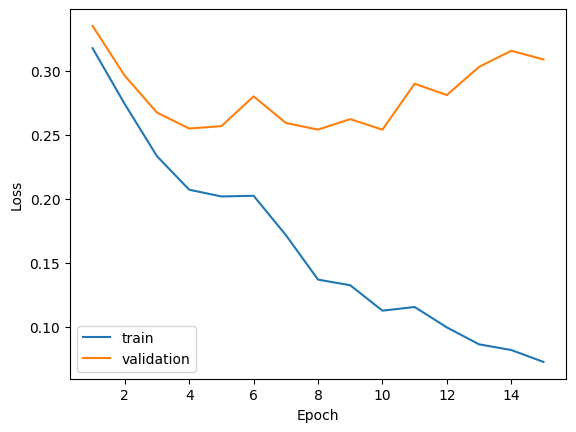

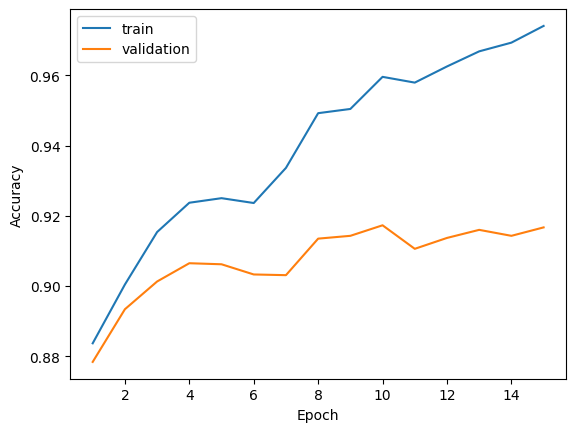

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.86      0.85      1013
     Trouser       0.99      0.98      0.99      1019
    Pullover       0.87      0.88      0.88      1009
       Dress       0.90      0.94      0.92      1006
        Coat       0.87      0.89      0.88       938
      Sandal       0.98      0.98      0.98       992
       Shirt       0.79      0.74      0.76      1026
     Sneaker       0.96      0.97      0.97      1004
         Bag       0.98      0.97      0.98       969
  Ankle Boot       0.98      0.96      0.97      1024

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



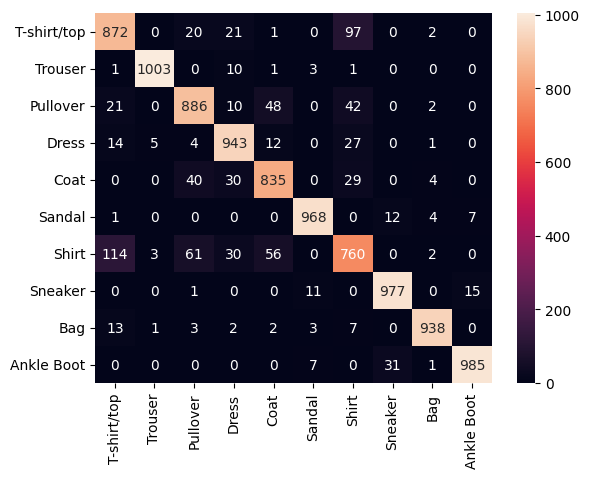

In [ ]:
model = Var1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses_train = []
losses_test = []
accs_train = []
accs_test = []

y_true_test, y_pred_test = train_test_loop(model, criterion, optimizer, epochs)

'''
train-set - loss: 0.10599491623366133, accuracy: 0.96004
test-set - loss: 0.2679275273800658, accuracy: 0.9186
EPOCH 11
'''

plot_loss(losses_train, losses_test, epochs)
plot_acc(accs_train, accs_test, epochs)
evaluate(y_true_test,y_pred_test)
